In [1]:
!nvidia-smi

Fri Mar 14 08:32:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:00:05.0 Off |                    0 |
| N/A   30C    P0             82W /  500W |   21111MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
!pip install rdkit

In [3]:
!pip install torch-geometric

In [4]:
!pip install molsets

  Using cached molsets-0.3.1-py3-none-any.whl.metadata (581 bytes)
  Using cached fcd_torch-1.0.7-py3-none-any.whl.metadata (2.9 kB)
  Using cached pomegranate-0.12.0.tar.gz (3.3 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [379 lines of output]
      /opt/conda/lib/python3.11/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /tmp/pip-install-jc0nob10/pomegranate_46c29808bebd499e9d3820b7222c3f12/pomegranate/BayesClassifier.pyx
        tree = Parsing.p_module(s, pxd, full_module_name)
      /opt/conda/lib/python3.11/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /tmp/pip-install-jc0nob10/pomegranate_46c29808bebd499e9d382

In [5]:
!pip install torch

In [6]:
!pip install pandas

In [7]:
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [8]:
!pip install scipy

In [9]:
atom_decoder = ['C', 'N', 'S', 'O', 'F', 'Cl', 'Br', 'H']

In [10]:
from typing import Any, Sequence
from rdkit import Chem, RDLogger
from rdkit.Chem.rdchem import BondType as BT
import os
import os.path as osp
import pathlib
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from torch_geometric.data import Data, InMemoryDataset, download_url
import pandas as pd

# Define the to_list function
def to_list(value: Any) -> Sequence:
    if isinstance(value, Sequence) and not isinstance(value, str):
        return value
    else:
        return [value]


In [11]:
from rdkit.Chem import MolFromSmiles, SanitizeMol

def compute_qed(smile):
    mol = MolFromSmiles(smile)
    if mol is None:
        return None  # Invalid SMILES
    try:
        SanitizeMol(mol)
        return QED.qed(mol)
    except Exception as e:
        print(f"Sanitization failed for SMILES: {smile}. Error: {e}")
        return None

In [55]:
# Dataloader that can provide QED Values
from rdkit import Chem, RDLogger
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import QED

import os
import os.path as osp
import pathlib
from typing import Any, Sequence

import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from torch_geometric.data import Data, InMemoryDataset, download_url
import pandas as pd

# from torch_geometric.data import DataEdgeAttr


class MOSESDataset(InMemoryDataset):
    train_url = 'https://media.githubusercontent.com/media/molecularsets/moses/master/data/train.csv'
    val_url = 'https://media.githubusercontent.com/media/molecularsets/moses/master/data/test.csv'
    test_url = 'https://media.githubusercontent.com/media/molecularsets/moses/master/data/test_scaffolds.csv'

    def __init__(self, stage, root, filter_dataset: bool, transform=None, pre_transform=None, pre_filter=None):
        self.stage = stage
        self.atom_decoder = atom_decoder
        self.filter_dataset = filter_dataset
        self.qed_one_counter = 0
        self.qed_zero_counter = 0
        if self.stage == 'train':
            self.file_idx = 0
        elif self.stage == 'val':
            self.file_idx = 1
        else:
            self.file_idx = 2
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[self.file_idx], weights_only=False)

    @property
    def raw_file_names(self):
        return ['train_moses.csv', 'val_moses.csv', 'test_moses.csv']

    @property
    def split_file_name(self):
        return ['train_moses.csv', 'val_moses.csv', 'test_moses.csv']

    @property
    def split_paths(self):
        r"""The absolute filepaths that must be present in order to skip
        splitting."""
        files = to_list(self.split_file_name)
        return [osp.join(self.raw_dir, f) for f in files]

    @property
    def processed_file_names(self):
        if self.filter_dataset:
            return ['train_filtered.pt', 'test_filtered.pt', 'test_scaffold_filtered.pt']
        else:
            return ['train.pt', 'test.pt', 'test_scaffold.pt']

    def download(self):
        import rdkit  # noqa
        train_path = download_url(self.train_url, self.raw_dir)
        os.rename(train_path, osp.join(self.raw_dir, 'train_moses.csv'))

        test_path = download_url(self.test_url, self.raw_dir)
        os.rename(test_path, osp.join(self.raw_dir, 'val_moses.csv'))

        valid_path = download_url(self.val_url, self.raw_dir)
        os.rename(valid_path, osp.join(self.raw_dir, 'test_moses.csv'))

    def process(self):
        print("Currently Processing Moses")
        RDLogger.DisableLog('rdApp.*')
        types = {atom: i for i, atom in enumerate(self.atom_decoder)}

        bonds = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3}

        path = self.split_paths[self.file_idx]
        df = pd.read_csv(path)
        smiles_list = df['SMILES'].values
        qed_list = df['QED'].values if 'QED' in df.columns else [None] * len(smiles_list)

        data_list = []
        smiles_kept = []
        print(len(smiles_list))
        turn_flag = 0
        for i, smile in enumerate(tqdm(smiles_list)):
            mol = Chem.MolFromSmiles(smile)
            if(i == 200000):
                break
            if mol is None:
                continue

            # Compute QED value
            # qed = QED.qed(mol)  # Compute QED using RDKit
            qed = compute_qed(smile)
            if(qed < 0.5):
                if(turn_flag == 1):
                    continue
                self.qed_zero_counter += 1
                turn_flag = 1
            else:
                if(turn_flag == 0):
                    continue
                self.qed_one_counter += 1
                turn_flag = 0
                
            N = mol.GetNumAtoms()
            type_idx = []
            for atom in mol.GetAtoms():
                type_idx.append(types[atom.GetSymbol()])

            row, col, edge_type = [], [], []
            for bond in mol.GetBonds():
                start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                row += [start, end]
                col += [end, start]
                edge_type += 2 * [bonds[bond.GetBondType()] + 1]

            if len(row) == 0:
                continue

            edge_index = torch.tensor([row, col], dtype=torch.long)
            edge_type = torch.tensor(edge_type, dtype=torch.long)
            edge_attr = F.one_hot(edge_type, num_classes=len(bonds) + 1).to(torch.float)

            perm = (edge_index[0] * N + edge_index[1]).argsort()
            edge_index = edge_index[:, perm]
            edge_attr = edge_attr[perm]

            x = F.one_hot(torch.tensor(type_idx), num_classes=len(types)).float()
            # print(qed)
            y = torch.tensor([round(qed)], dtype=torch.long)  # Store QED value in y
            # print(y)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, idx=i) # the y does not update...
            # print(data.y)

            if self.filter_dataset:
                # Try to build the molecule again from the graph. If it fails, do not add it to the training set
                dense_data, node_mask = utils.to_dense(data.x, data.edge_index, data.edge_attr, data.batch)
                dense_data = dense_data.mask(node_mask, collapse=True)
                X, E = dense_data.X, dense_data.E

                assert X.size(0) == 1
                atom_types = X[0]
                edge_types = E[0]
                mol = build_molecule_with_partial_charges(atom_types, edge_types, atom_decoder)
                smiles = mol2smiles(mol)
                if smiles is not None:
                    try:
                        mol_frags = Chem.rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=True)
                        if len(mol_frags) == 1:
                            data_list.append(data)
                            smiles_kept.append(smiles)

                    except Chem.rdchem.AtomValenceException:
                        print("Valence error in GetmolFrags")
                    except Chem.rdchem.KekulizeException:
                        print("Can't kekulize molecule")
            else:
                if self.pre_filter is not None and not self.pre_filter(data):
                    continue
                if self.pre_transform is not None:
                    data = self.pre_transform(data)
                data_list.append(data)

        torch.save(self.collate(data_list), self.processed_paths[self.file_idx])
        if self.filter_dataset:
            smiles_save_path = osp.join(pathlib.Path(self.raw_paths[0]).parent, f'new_{self.stage}.smiles')
            print(smiles_save_path)
            with open(smiles_save_path, 'w') as f:
                f.writelines('%s\n' % s for s in smiles_kept)
            print(f"Number of molecules kept: {len(smiles_kept)} / {len(smiles_list)}")

In [56]:
dataset = MOSESDataset(stage='train', root='./data/moses', filter_dataset=False)

Processing...


Currently Processing Moses
1584663


 13%|█▎        | 200000/1584663 [04:04<28:13, 817.54it/s]
Done!


In [57]:
dataset = dataset.shuffle()

print(dataset.qed_one_counter)
print(dataset.qed_zero_counter)
print(dataset[1])
print("Number of Nodes (x):")
print(dataset[0].x)
print("Edge index:")
print(dataset[0].edge_index)
print("Labels (y):")
print(dataset.y)
print(len(dataset))

3018
3018
Data(x=[21, 8], edge_index=[2, 46], edge_attr=[46, 5], y=[1], idx=[1])
Number of Nodes (x):
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.]])
Edge index:
tensor([[ 0,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  5,  6,  7,  7,  8,
          9,  9, 10, 10, 10, 11, 11, 12, 13, 13,

In [58]:
#Improved GIN Model
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, Mish
from torch_geometric.nn import GINConv, global_add_pool

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), Mish(),
                       Linear(dim_h, dim_h), Mish()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), Mish(),
                       Linear(dim_h, dim_h), Mish()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), Mish(),
                       Linear(dim_h, dim_h), Mish()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h, F.log_softmax(h, dim=1)


gin_original = GIN(dim_h=32)

In [59]:
print(len(dataset))

6036


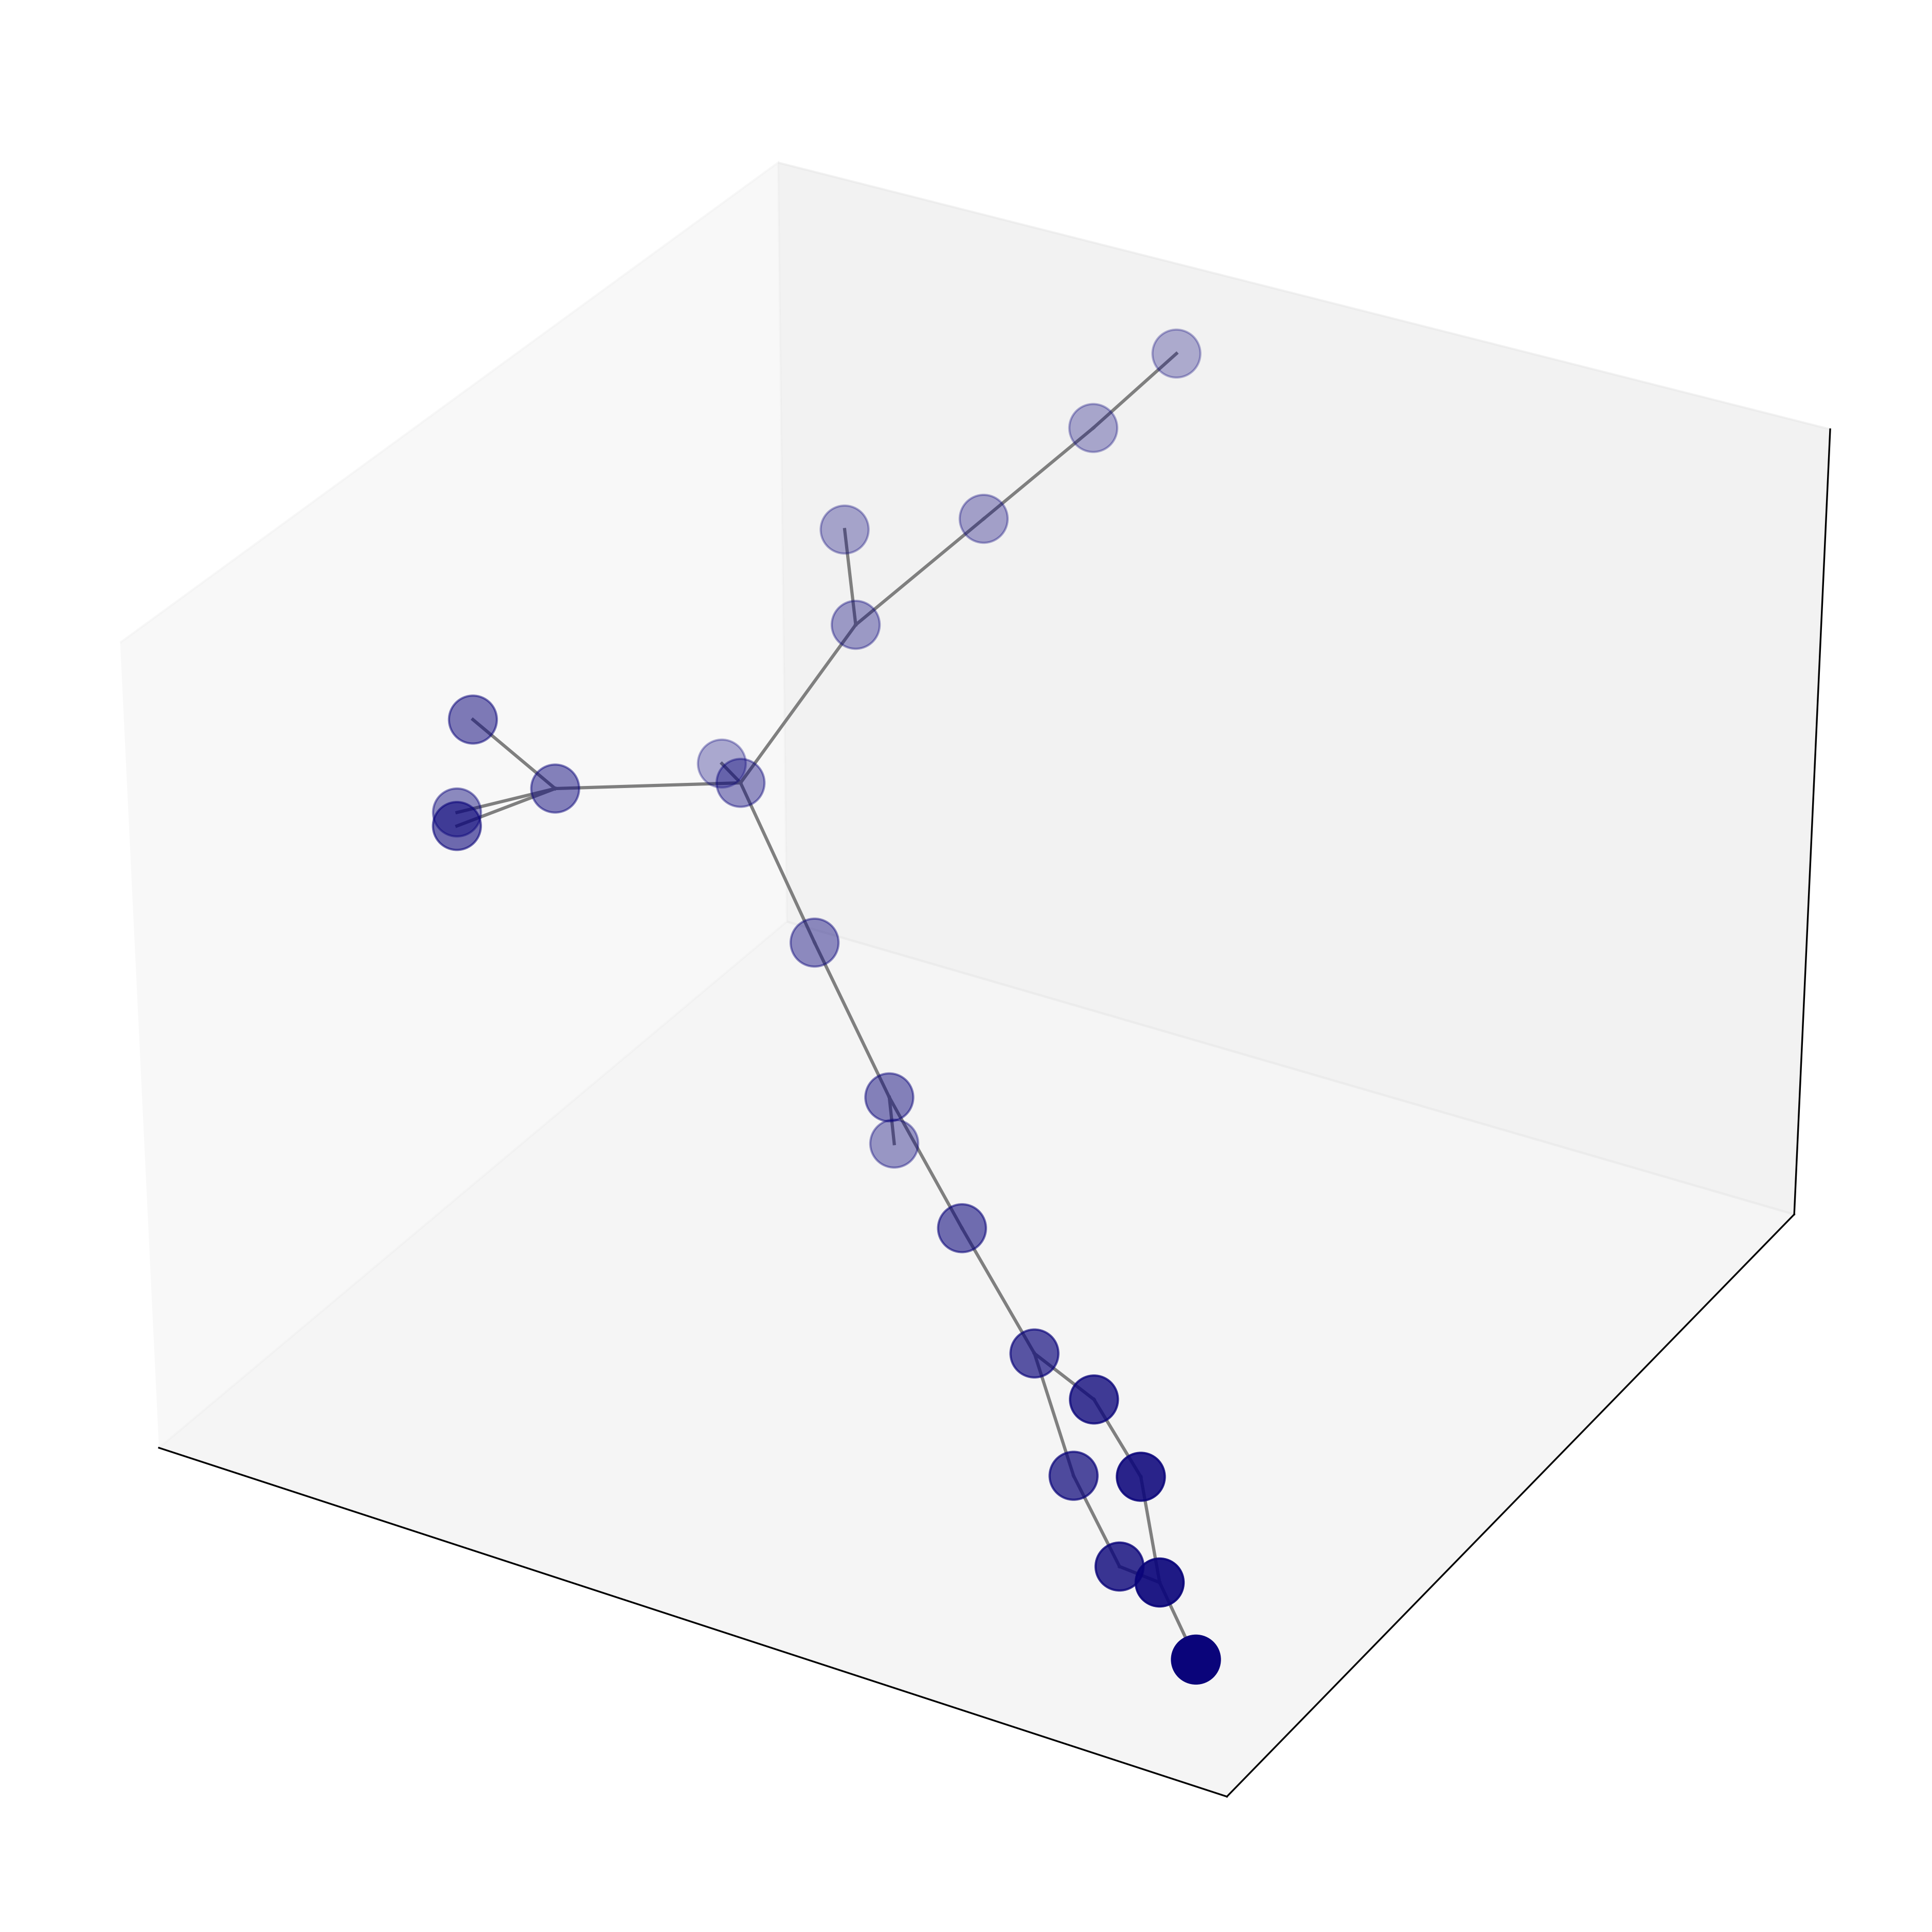

In [60]:
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[2], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

In [61]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nTest loader:')
for i, subgraph in enumerate(test_loader):
    print(f' - Subgraph {i}: {subgraph}')

Training set   = 4828 graphs
Validation set = 604 graphs
Test set       = 604 graphs

Train loader:
 - Subgraph 0: DataBatch(x=[1406, 8], edge_index=[2, 3020], edge_attr=[3020, 5], y=[64], idx=[64], batch=[1406], ptr=[65])
 - Subgraph 1: DataBatch(x=[1410, 8], edge_index=[2, 3044], edge_attr=[3044, 5], y=[64], idx=[64], batch=[1410], ptr=[65])
 - Subgraph 2: DataBatch(x=[1368, 8], edge_index=[2, 2946], edge_attr=[2946, 5], y=[64], idx=[64], batch=[1368], ptr=[65])
 - Subgraph 3: DataBatch(x=[1359, 8], edge_index=[2, 2912], edge_attr=[2912, 5], y=[64], idx=[64], batch=[1359], ptr=[65])
 - Subgraph 4: DataBatch(x=[1371, 8], edge_index=[2, 2934], edge_attr=[2934, 5], y=[64], idx=[64], batch=[1371], ptr=[65])
 - Subgraph 5: DataBatch(x=[1408, 8], edge_index=[2, 3046], edge_attr=[3046, 5], y=[64], idx=[64], batch=[1408], ptr=[65])
 - Subgraph 6: DataBatch(x=[1375, 8], edge_index=[2, 2964], edge_attr=[2964, 5], y=[64], idx=[64], batch=[1375], ptr=[65])
 - Subgraph 7: DataBatch(x=[1379, 8], e

In [66]:
import torch

# Check if GPU is available....
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def train(model, loader, val_loader, test_loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
    epochs = 100


    model = model.to(device)

    model.train()
    for epoch in range(epochs + 1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
            # Move data to GPU !!!!!
            data = data.to(device)

            optimizer.zero_grad()
            _, out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward()
            optimizer.step()

        # Validation
        val_loss, val_acc = test(model, val_loader)

        # Print metrics every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
                  f'| Train Acc: {acc * 100:>5.2f}% '
                  f'| Val Loss: {val_loss:.2f} '
                  f'| Val Acc: {val_acc * 100:.2f}%')

    # Test
    test_loss, test_acc = test(model, test_loader)
    print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc * 100:.2f}%')

    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:

        data = data.to(device)

        _, out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gin = GIN(dim_h=32)

gin = gin.to(device)


gin = train(gin, train_loader, val_loader, test_loader)

Using device: cuda
Epoch   0 | Train Loss: 0.75 | Train Acc: 62.74% | Val Loss: 0.63 | Val Acc: 64.44%
Epoch  10 | Train Loss: 0.57 | Train Acc: 70.99% | Val Loss: 0.58 | Val Acc: 67.41%
Epoch  20 | Train Loss: 0.56 | Train Acc: 70.61% | Val Loss: 0.58 | Val Acc: 71.83%
Epoch  30 | Train Loss: 0.55 | Train Acc: 71.77% | Val Loss: 0.56 | Val Acc: 70.47%
Epoch  40 | Train Loss: 0.56 | Train Acc: 71.36% | Val Loss: 0.57 | Val Acc: 71.21%
Epoch  50 | Train Loss: 0.55 | Train Acc: 71.81% | Val Loss: 0.56 | Val Acc: 70.74%
Epoch  60 | Train Loss: 0.55 | Train Acc: 72.51% | Val Loss: 0.56 | Val Acc: 73.08%
Epoch  70 | Train Loss: 0.54 | Train Acc: 72.94% | Val Loss: 0.55 | Val Acc: 72.70%
Epoch  80 | Train Loss: 0.55 | Train Acc: 72.13% | Val Loss: 0.56 | Val Acc: 71.25%
Epoch  90 | Train Loss: 0.53 | Train Acc: 73.74% | Val Loss: 0.51 | Val Acc: 76.36%
Epoch 100 | Train Loss: 0.52 | Train Acc: 75.07% | Val Loss: 0.51 | Val Acc: 78.28%
Test Loss: 0.51 | Test Acc: 74.64%


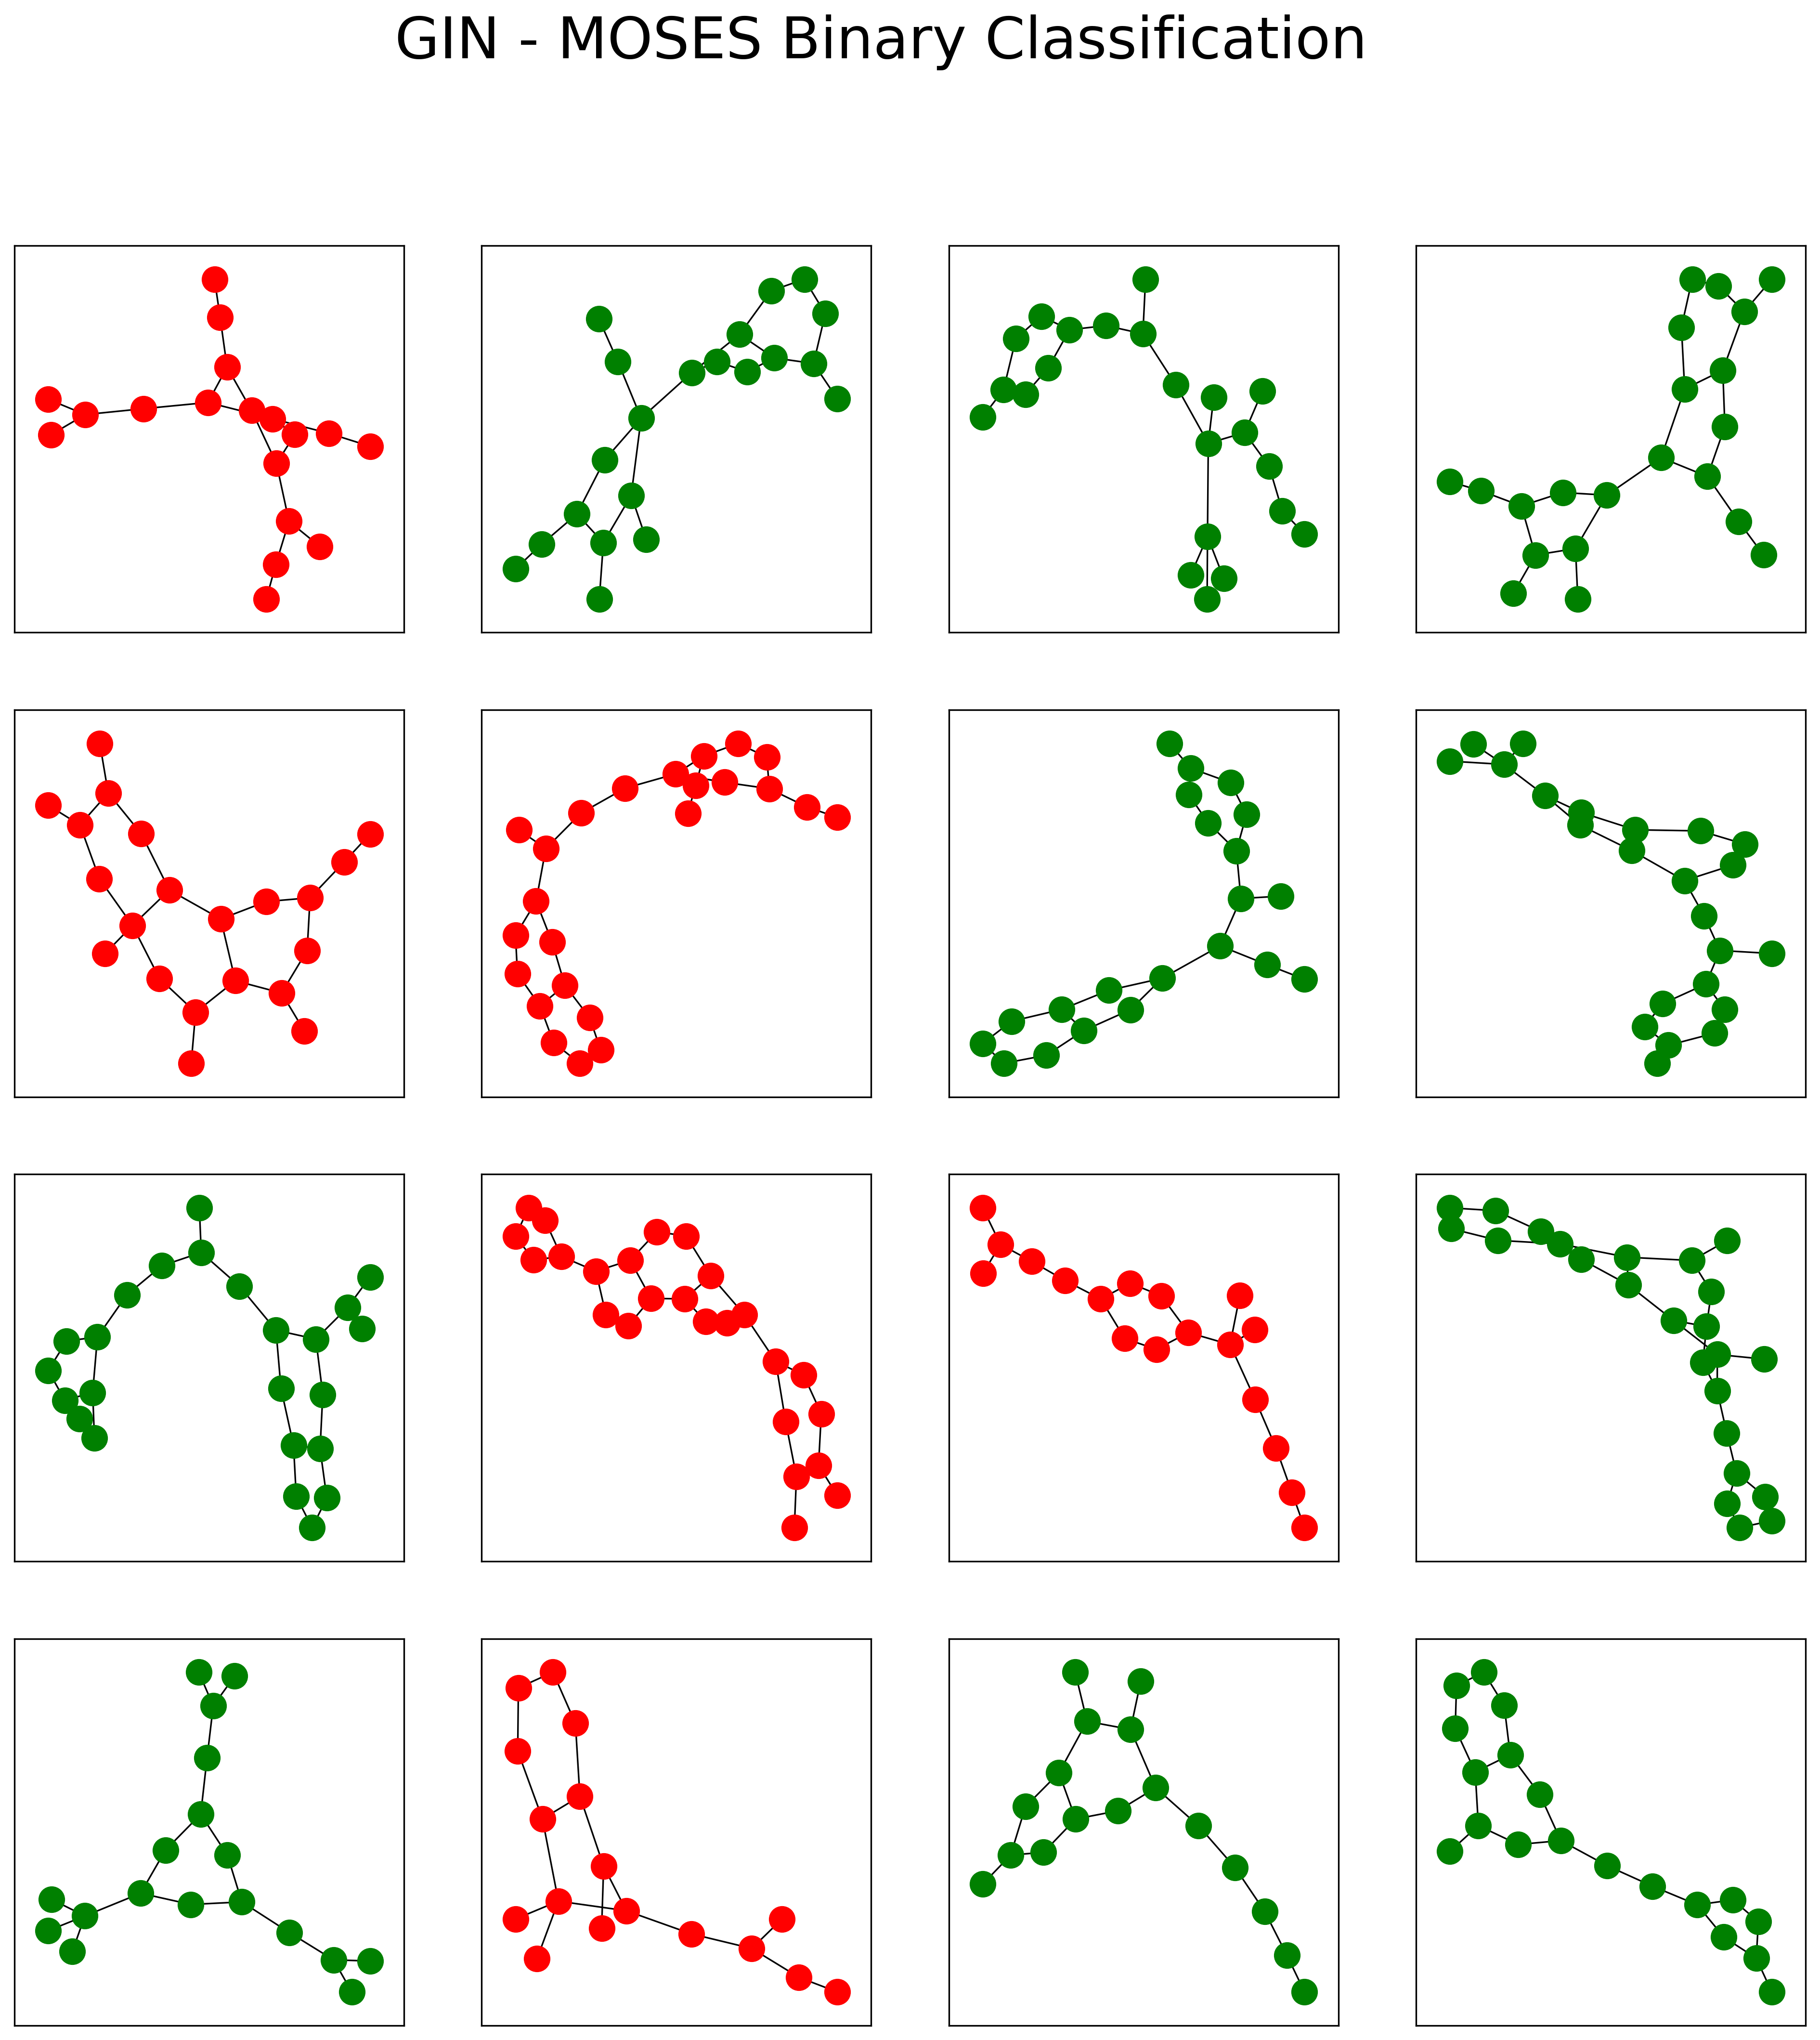

In [71]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN - MOSES Binary Classification')

for i, data in enumerate(dataset[1113-16:1113]):
    data = data.to(device)
    _, out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('on')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )